# Project: Investigate the Gapminder Africa Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
This analysis will look into three datasets of the gapminder foundation (Gapminder.org).
Although many countries are represented in the dataset, I will focus on countries in Africa. I chose this focus as I do not know very much about Africa and would like to get to know it at least by the numbers.

The datasets are the following:
 -  Income per Person (GDP per Capita)
 -  Children per woman
 -  Mortality rate of newborns
 -  Countries in Africa (For data cleaning purposes only)
 
All datasets have data for each country and each year.
The analysis will look at the development of each dataset over the years and will graphically compare the developments. 

Core questions are:
 - How does the GDP per Capita change for African countries
     - By how much did each country increase/decrease?
     - Which countries had the largest gain and which countries the smallest?
 - Is there a correlation between the mortality rate of newborns and the GDP?
     - How big is the difference between the winners and the losers of GDP growth?
 - How does the mortality rate affect the children per woman?
     - Is there a correclation between the mortality rate and the children per woman?
     - How do the three variables GDP, mortality rate and children per woman effect each other?
    

In [23]:
# Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

### General Properties
First the four datasets are loaded and inspected for their shape and if their countries match

In [24]:
# Gross domestic product dataframe
gdp = pd.read_csv("income_per_person_gdppercapita_ppp_inflation_adjusted.csv")
# Children per woman (cpw) dataframe
cpw = pd.read_csv("children_per_woman_total_fertility.csv")
# Child mortality rate (cmr) dataframe
cmr = pd.read_csv("child_mortality_0_5_year_olds_dying_per_1000_born.csv")
# Countries with the according continent (from GitHub)
c2c = pd.read_csv("continent_to_country.csv")

#### Inspect
It is important that the datasets have the same shape, since I want to combine them in a later part of the project

In [25]:
cpw.shape, cmr.shape, gdp.shape

((184, 220), (193, 220), (193, 242))

In [26]:
gdp.head(1)

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,Afghanistan,603,603,603,603,603,603,603,603,603,...,2420,2470,2520,2580,2640,2700,2760,2820,2880,2940


In [27]:
cpw.head(1)

,country,1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,6.04,5.82,5.6,5.38,5.17,4.98,4.8,4.64,4.48,4.33


In [28]:
gdp.info(), cpw.info(), cmr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Columns: 242 entries, country to 2040
dtypes: int64(241), object(1)
memory usage: 365.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Columns: 220 entries, country to 2018
dtypes: float64(219), object(1)
memory usage: 316.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Columns: 220 entries, country to 2018
dtypes: float64(219), object(1)
memory usage: 331.8+ KB


(None, None, None)

In [29]:
# Checks wheather each country is only represented once
gdp.country.value_counts().nunique(), cpw.country.value_counts().nunique(), cmr.country.value_counts().nunique()

(1, 1, 1)

#### Adjust columns
The three dataframes neither match in row nor column count.
In a first effort the columns of the gdp dataset are omitted, since they forecast into the future.

The rowcount is depending on the countries represented in the dataframes. Before they are being aligned, all datasets are reduced to African-only countries. Maybe the missing countries are all non-African.

In [30]:
# Getting rid of the predictions in the GDP dataset and keeping only the years until 2018:
gdp.drop(gdp.columns[list(np.arange(220,242))], axis=1, inplace = True)
print(list(gdp.columns) == list(cpw.columns))
print(list(cmr.columns) == list(cpw.columns))
# Now all columns match

True
True


#### Create African countries list
Now that the columns are the same for all dataframes, the countries will be reduced to African countries only.
The dataset with the African countries is inspected, and some country names are adjusted, since they do not match the names in the dataframe.

Afterwards a list is created, which contains all the African countries.

In [31]:
c2c.head(1)

,Continent,Country,Column,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9
0,Africa,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Get a list of the African countries
c2c.query('Continent == "Africa"', inplace = True)

# Adjust country names so they are the same for all datasets
old_names = ["Burkina",
    "Congo",
    "Congo, Democratic Republic of",
    "Ivory Coast"]
new_names = ["Burkina Faso",
    "Congo, Rep.",
    "Congo, Dem. Rep.",
    "Cote d'Ivoire"]

# Change the names
for i, match in enumerate(old_names):  
    c2c.loc[c2c["Country"] == match] = new_names[i]
    
# Create a list of African countries
african_countries = list(c2c.Country)
len(set(african_countries))
# The African country list seems to be complete

54

#### Reduce dataframe rows
Now each country in each dataframe is checked whether it is an African country. If not, the row is deleted.

In [33]:
# Matching all datasets against the list of African countries to reduce them to Africa
for df in [gdp, cpw, cmr]:
    for match in df.country:
        if match not in african_countries:
            # If the country is not in Africa the country is dropped
            df.drop(df.index[df['country'] == match], inplace = True)
# Check if the datasets have been successfully reduced to Africa
cmr.shape, gdp.shape, cpw.shape        

((54, 220), (54, 220), (54, 220))

All datasets now contain 54 rows (54 countries in Africa) and 220 columns (data for 219 year and one index column with the country). Now it is possible to combine and compare the data between the three datasets.

#### Check value types of the dataframes
Now that all dataframes have the same shape and matching rows and columns the values are inspected.
First it is checked wheather each cell has a value and in a second step if they are all floats (ints for the gdp dataset). 

In [34]:
# Checking if any values are missing
cpw.isnull().any(axis=1).sum(), gdp.isnull().any(axis=1).sum(), cmr.isnull().any(axis=1).sum()

(0, 0, 0)

In [35]:
# Use the countryname as the index
cpw.set_index('country', inplace = True)
gdp.set_index('country', inplace = True)
cmr.set_index('country', inplace = True)

In [36]:
# Check if all datatypes are correct
cpw.dtypes.all(), gdp.dtypes.all(), cmr.dtypes.all()

(dtype('float64'), dtype('int64'), dtype('float64'))

#### To make sure to have correct values each dataframe gets plotted
 - Children per woman: The max value of each year.
 - Child mortality rate: The max value of each year.
 - GDP: The max value for each year.

All graphs look like they are in reasonable areas. The "max children per woman" graph shows no fluctuation before 1925 which is odd, but could be because one country consistently had the highest cpw count. The "min children per woman" graph shows movement well before 1925, so the dataset seems to be fine.

##### Max children per woman

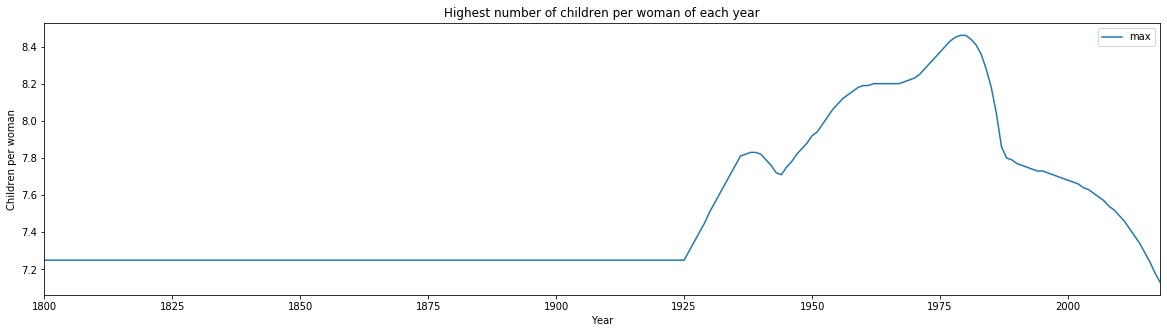

In [50]:
max_values = cpw.describe().loc["max"]
pd.DataFrame(max_values).plot.line(figsize= (20,5))
plt.title("Highest number of children per woman of each year")
plt.xlabel("Year")
plt.ylabel("Children per woman");

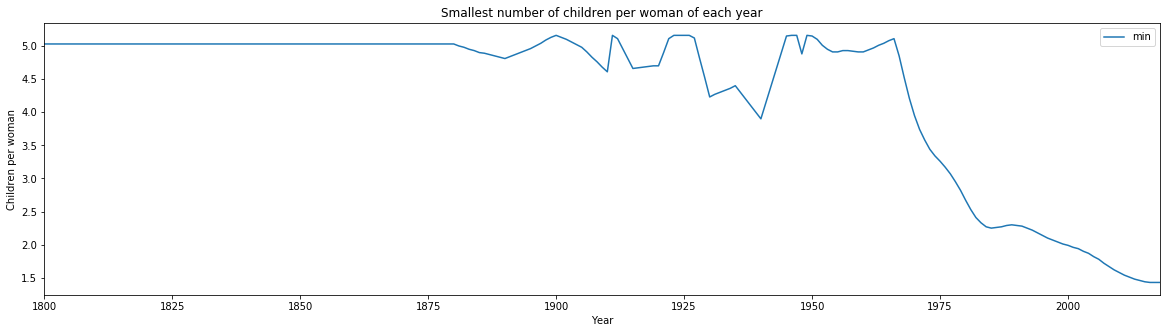

In [53]:
max_values = cpw.describe().loc["min"]
pd.DataFrame(max_values).plot.line(figsize= (20,5));
plt.title("Smallest number of children per woman of each year")
plt.xlabel("Year")
plt.ylabel("Children per woman");

##### Max child mortality rate (0 to 5 year olds dying per 1000 born)

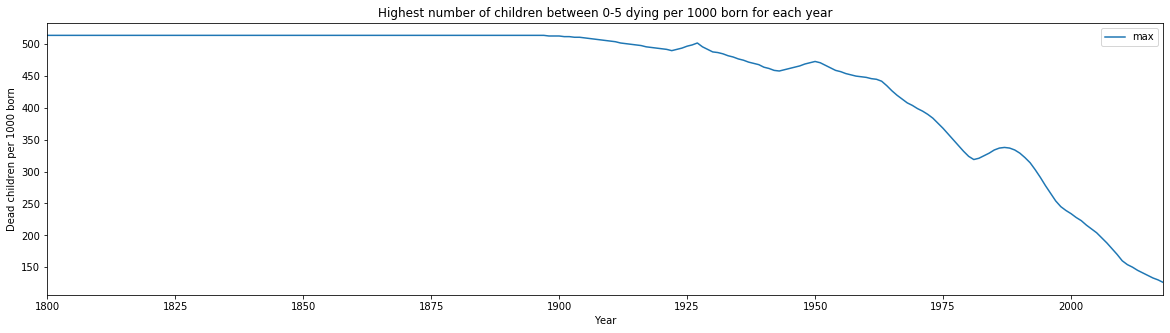

In [56]:
max_values = cmr.describe().loc["max"]
pd.DataFrame(max_values).plot.line(figsize= (20,5));
plt.title("Highest number of children between 0-5 dying per 1000 born for each year")
plt.xlabel("Year")
plt.ylabel("Dead children per 1000 born");

##### Max GDP

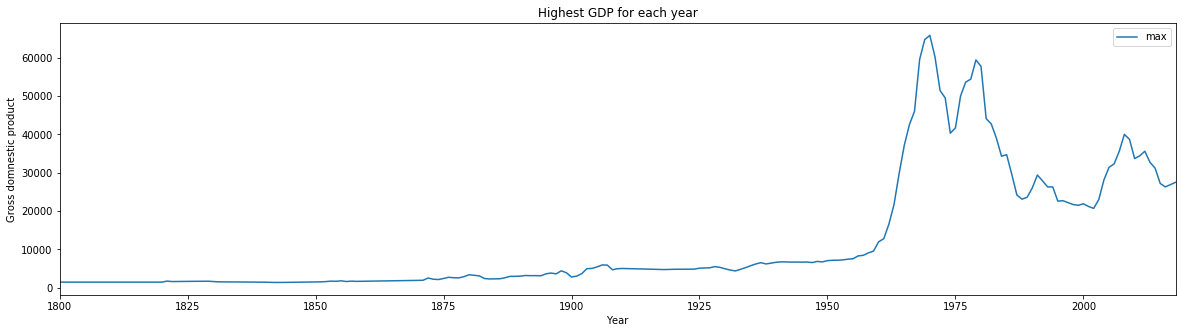

In [57]:
max_values = gdp.describe().loc["max"]
pd.DataFrame(max_values).plot.line(figsize= (20,5));
plt.title("Highest GDP for each year")
plt.xlabel("Year")
plt.ylabel("Gross domnestic product");

<a id='eda'></a>
## Exploratory Data Analysis

### 1) How does the GDP per Capita change for African countries?



In [62]:
# Extracting the mean, max and min values of all countries for each year and saving them in a dataframe
mean_values = gdp.describe().loc["mean"]
graph = pd.DataFrame(mean_values)
graph["Highest"] = gdp.describe().loc["max"]
graph["Average"] = graph["mean"]
graph.drop(columns = "mean", axis = 1, inplace = True)
graph["Smallest"] = gdp.describe().loc["min"]


##### Mean, max, min over the years
The graph below shows that Africa developed only very slowly until about 1960. Until then the highest GDP increased very slowly and the majority of countries (indicated by the 'mean' values) had a very low GDP.
After 1960 at least one country skyrocketed in terms of GDP and thus economic growth. It fell back again in the following 20 years but stayed at a significant higher level.
In the next graph I will rank the countries by growth to identify the ones whose economies skyrocketed.

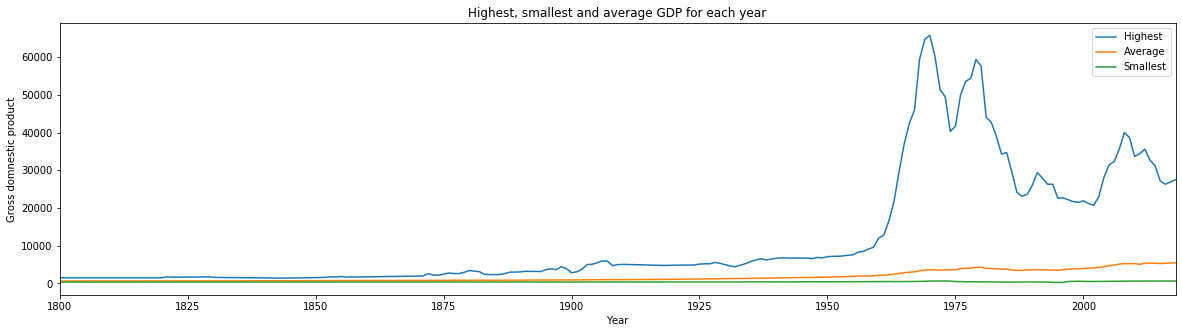

In [63]:
graph.plot.line(figsize = (20,5));
plt.title("Highest, smallest and average GDP for each year")
plt.xlabel("Year")
plt.ylabel("Gross domnestic product");

#### 1.1 & 1.2) By how much did each country increase/decrease? Who had the biggest gains?



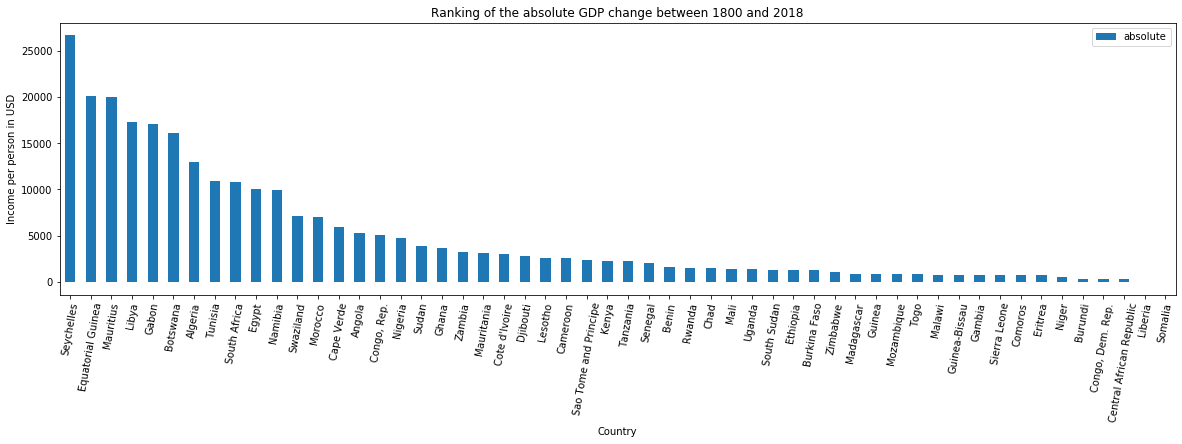

In [91]:
# Creates a copy so I don't mess with the original data
change = gdp.copy()
# Calculates the absolute change in GDP (since all countries had very similar GDPs in 1800 the percentage change is omitted)
change["absolute"] = change["2018"]-change["1800"]
# Sorts the df by the absolute change
change.sort_values(by = "absolute", inplace = True, ascending = False)
# Draws a bar graph
change.drop(change.columns[list(np.arange(0,219))], axis = 1, inplace = True)
change.plot.bar(figsize = (20,5), rot = 80)
plt.ylabel("Income per person in USD")
plt.xlabel("Country")
plt.title("Ranking of the absolute GDP change between 1800 and 2018");

The bar graph above shows that especially the Seychelles, Guinea and Mauritius had large gains in their income per person.

#### 1.3) Distribution of the GDP across the countries

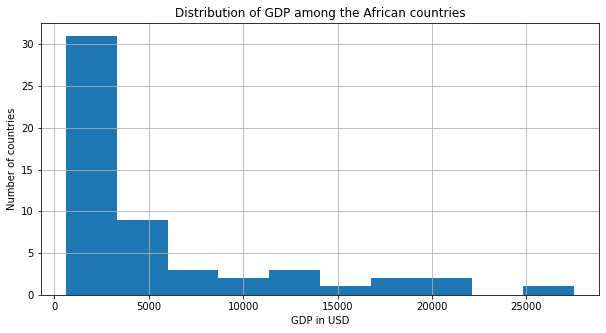

In [103]:
gdp["2018"].hist(bins = 10, figsize = (10,5))
plt.title("Distribution of GDP among the African countries")
plt.xlabel("GDP in USD")
plt.ylabel("Number of countries");

The histogramm shows that the distribution of income between the Afre

### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!